In [1]:
import os
import pandas as pd
import numpy as np
import FunctionsAndData as fd

directory = '/Users/ilanastern/Desktop/aiConfidential/data'

def influence_matrix(directory):
    all_contributions = {}  # Dictionary

    for root, _, files in os.walk(directory):  # Loop through each file in the directory
        for file_name in files:
            file_path = os.path.join(root, file_name)

            # Loop only relevant files and assign either as training or validation
            if file_name.endswith(".csv") and file_name.startswith("eval_loss_meta"):
                if root.endswith("_TR.eval"):
                    split_type = "train"
                elif root.endswith("_VL.eval"):
                    split_type = "validation"
                else:
                    continue  # Skip all files that arent eval_loss_meta training

                try: #load file in 
                    data = pd.read_csv(file_path)
                except Exception as e:
                    print(f"Error reading {file_path}: {e}")
                    continue

                avg_f1 = data['f1'].mean() #average f1 score for the file

                for _, row in data.iterrows(): # Contribution to F1 score for each data point
                    datapoint_id = row['idx']
                    f1_score = row['f1']
                    contribution = f1_score - avg_f1

                    if datapoint_id not in all_contributions:
                        all_contributions[datapoint_id] = [] #making sure each data point has a list of contributions
                    all_contributions[datapoint_id].append(contribution)

    unique_datapoints = list(all_contributions.keys()) # list of all datapoints for future plotting
    num_points = len(unique_datapoints)

    pairwise_matrix = np.zeros((num_points, num_points)) # creating pairwise matrix

    for i, dp1 in enumerate(unique_datapoints): # Calculating influnces
        for j, dp2 in enumerate(unique_datapoints):
            if i == j:
                pairwise_matrix[i, j] = 0 # A data point's influence on itself is 0
            else:
                pairwise_matrix[i, j] = np.mean(all_contributions[dp1]) - np.mean(all_contributions[dp2]) # Influence of dp1 on dp2

    pairwise_df = pd.DataFrame(pairwise_matrix,index=unique_datapoints,columns=unique_datapoints) #making matrix into a dataframe

    return pairwise_df
pairwise_influence_df = influence_matrix(directory)



## New Influnce Score

In [2]:
def influence_matrix_updated(directory):
    all_contributions = {}  # Dictionary to store contributions
    file_metadata = []  # List of file path and type
    train_file_data = {}  # Dictionary to store training file contents 
    
    for root, _, files in os.walk(directory): # Collect file paths for processing
        for file_name in files:
            if file_name.endswith(".csv") and file_name.startswith("eval_loss_meta"):
                split_type = "train" if root.endswith("_TR.eval") else "validation" if root.endswith("_VL.eval") else None #loading files in and assigning as TR or VL
                if split_type:
                    file_metadata.append((os.path.join(root, file_name), split_type)) #adding to storage

    # Load validation files first. This only looks at the validation files not the training files yet
    for file_path, split_type in file_metadata:
        if split_type != "validation":
            continue  # Skip training files here

        try:
            data = pd.read_csv(file_path, usecols=['idx', 'f1']) # Load only necessary columns of idx and f1
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        avg_f1 = data['f1'].mean() #average f1 score for the file across all idx valued
        contributions = data.assign(contribution=data['f1'] - avg_f1).groupby('idx')['contribution'].apply(list) #finds the difference between the f1 score for each point and the average of that file

        for idx, contrib_list in contributions.items(): #storing the contribution of each data point to the dictionary
            all_contributions.setdefault(idx, []).extend(contrib_list)

    unique_datapoints = list(all_contributions.keys()) # list of all datapoints for future plotting
    num_points = len(unique_datapoints) # Number of unique data points

    mean_contributions = {dp: np.mean(contribs) for dp, contribs in all_contributions.items()} # Precompute mean contributions

    # Load all training files into memory for fast lookup
    for file_path, split_type in file_metadata:
        if split_type == "train":
            try:
                data = pd.read_csv(file_path, usecols=['idx'])
                train_file_data[file_path] = set(data['idx'].values)  # Store set of indices for lookup
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    pairwise_matrix = np.zeros((num_points, num_points)) # Initialize pairwise matrix

    for i, dp1 in enumerate(unique_datapoints): #iterates over all datapoints to calculate influnce
        for j, dp2 in enumerate(unique_datapoints):
            if i == j:
                continue  # Skip point if trying to find influnce on self

            total_contributions = []

            # Check each file in file_metadata
            for file_path, split_type in file_metadata: # For influnce of i on j, skip files where j is in training set
                if split_type == "train" and dp2 in train_file_data[file_path]:
                    continue  # Skip this training file if dp2 is in it

                # Compute influence only using allowed validation and training files
                if dp1 in mean_contributions and dp2 in mean_contributions:
                    total_contributions.append(mean_contributions[dp1] - mean_contributions[dp2]) #Finds difference in mean contributions between i and j

            # Compute mean influence or assign 0 if no contributions exist
            pairwise_matrix[i, j] = np.mean(total_contributions) if total_contributions else 0 #storing data or assigning value of zero

    pairwise_df = pd.DataFrame(pairwise_matrix, index=unique_datapoints, columns=unique_datapoints) #making matrix into a dataframe
    
    return pairwise_df

pairwise_influence_df_updated = influence_matrix_updated(directory)

## Previous Influnce Score Code
This code features the graph of, for the influnce of i on j, the influnce score does not omit data for when j is included in the training data

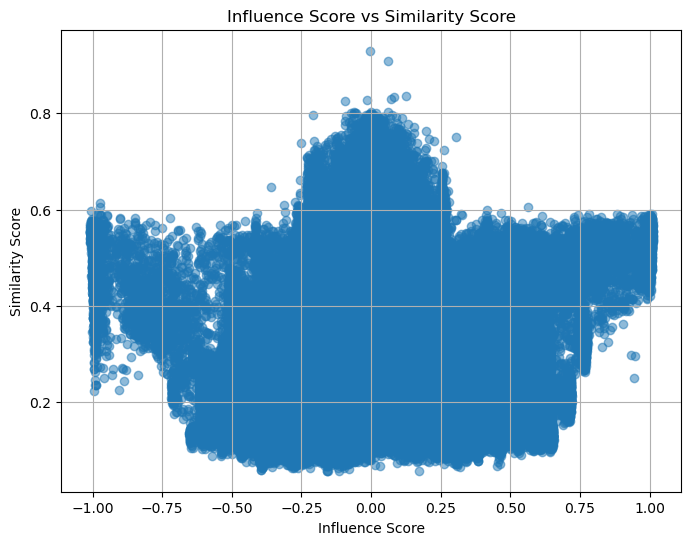

In [3]:
import FunctionsAndData as fd
fd.plot_influence_vs_similarity(pairwise_influence_df )

## Updated Influnce score (omits cases when point j is in the training data)

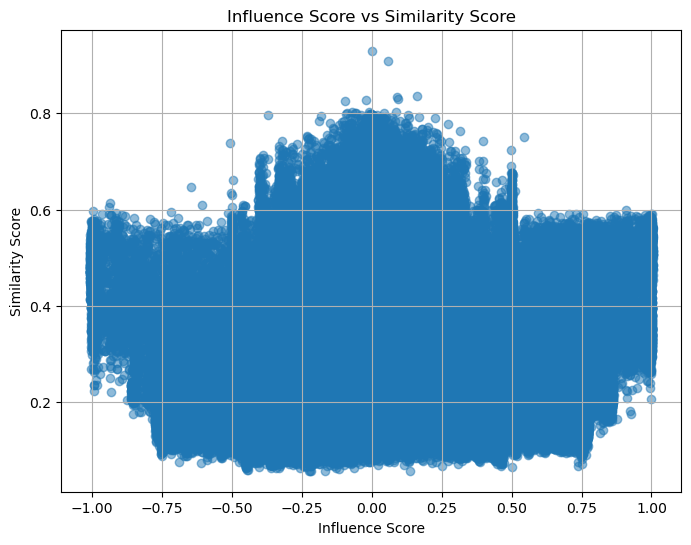

In [4]:
fd.plot_influence_vs_similarity(pairwise_influence_df_updated)